Based on implementation:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
import csv
import string
import seaborn as sns

In [2]:
from stop_words import get_stop_words
stop_words = get_stop_words('polish')
stop_words.extend(["ale"])
# stop_words.extend(["i", "o", "a", "z", "w", "u", "ze"])
# print(stop_words)

In [3]:
def create_vocabulary(documents):
    vocabulary = []
    for doc in documents:
        for word in doc:
            if word not in vocabulary:
                vocabulary.append(word)
    return vocabulary


def read_files(file_dir):
    real_documents = []
    lengths = []
    vocabulary = []

    for file in os.listdir(file_dir):
        file_path = os.path.join(file_dir, file)
        with open(file_path, 'r', newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=' ')
            text = []
            for row in reader:
                row = [''.join(c for c in s if c not in string.punctuation) for s in row]
                row = [s.lower() for s in row]
                text.extend(row)
            text = [word for word in text if len(word) > 2]
            text = [word for word in text if word not in stop_words]
            vocab = [word for word in text if word not in vocabulary]
            vocab = list(dict.fromkeys(vocab))
            vocabulary.extend(vocab)
            real_documents.append(text)
            lengths.append(len(text))
            print("document {} loaded, length: {}, vocab: {}".format(file_path, len(text), len(vocabulary)))

    print("docs ", len(real_documents))

    # vocabulary = create_vocabulary(real_documents)
    min_length = min(lengths)
    # min_length = 300
    print("Min length: ", min_length)
    print("Max length: ", max(lengths))
    truncated_documents = []
    for document in real_documents:
        if len(document) > min_length:
            truncated_documents.append(document[:min_length])
    #         real_documents.append(document[min_length:])
        elif len(document) < min_length:
            pass
        else:
            truncated_documents.append(document)
    # print(truncated_documents)

    vocabulary = create_vocabulary(truncated_documents)

    print("Words ", len(vocabulary))
    print("Documents: ", len(truncated_documents))
    return truncated_documents, vocabulary

In [5]:
%%time

file_dir = "test_dir"
documents, vocabulary = read_files(file_dir)

document test_dir\test.txt loaded, length: 116, vocab: 12
document test_dir\test2.txt loaded, length: 102, vocab: 20
document test_dir\test3.txt loaded, length: 156, vocab: 26
document test_dir\test4.txt loaded, length: 150, vocab: 26
document test_dir\test5.txt loaded, length: 138, vocab: 32
docs  5
Min length:  102
Max length:  156
Words  32
Documents:  5
Wall time: 12 ms


In [6]:
K = 3  # number of topics
V = len(vocabulary)  # number of words
M = len(documents)  # number of documents
N = len(documents[0])  # number of words per document

print("Topics: {}, Words: {}, Documents: {}, Words per doc: {}".format(K, V, M, N))

Topics: 3, Words: 32, Documents: 5, Words per doc: 102


In [9]:
print(documents)

# Create Dictionary
id2word = corpora.Dictionary(documents)

# Create Corpus
texts = documents

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus)

[['leki', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'lekarz', 'lekarz', 'weterynarz', 'weterynarze', 'lekarze', 'psy', 'koty', 'leki', 'przeciwbólowe', 'medycyna', 'lekarz', 'lekarz', 'weterynarz', 'ludzie', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'lekarz', 'lekarz', 'weterynarz', 'medycyna', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'leki', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'weterynarz', 'lekarz', 'lekarz', 'lekarz', 'weterynarz', 'weterynarze', 'lekarze', 'psy', 'koty', 'leki', 'przeciwbólowe', 'medycyna', 'lekarz', 'lekarz', 'weterynarz', 'ludzie', 'lekarz', 'weterynarz', 'pies', 'kot', 'lekarz', 'pies', 'kot', 'weterynarz', 'l

In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=K, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.335*"pilka" + 0.284*"gol" + 0.080*"wyniki" + 0.054*"sport" + '
  '0.028*"ludzie" + 0.028*"bramka" + 0.028*"oraz" + 0.028*"pilkarz" + '
  '0.028*"sportowcy" + 0.017*"lekarz"'),
 (1,
  '0.440*"lekarz" + 0.134*"weterynarz" + 0.095*"leki" + 0.051*"medycyna" + '
  '0.046*"przeciwbólowe" + 0.046*"lekarze" + 0.024*"kot" + 0.020*"złamana" + '
  '0.018*"pies" + 0.016*"ból"'),
 (2,
  '0.518*"pies" + 0.333*"kot" + 0.016*"koty" + 0.016*"psy" + 0.015*"człowieka" '
  '+ 0.015*"właściciel" + 0.015*"najlepszy" + 0.015*"ryby" + '
  '0.015*"przyjaciel" + 0.010*"obroża"')]


In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -1.8853927141311122

Coherence Score:  0.27938379963637927


In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

d:\programowanie\python\machine-learning-tests\venv\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.312852  0.112967       1        1  43.406864
1     -0.037285 -0.278963       2        1  36.587906
0     -0.275567  0.165996       3        1  20.005228, topic_info=   Category        Freq           Term       Total  loglift  logprob
7   Default  118.000000           pies  118.000000  30.0000  30.0000
2   Default   84.000000         lekarz   84.000000  29.0000  29.0000
15  Default   34.000000          pilka   34.000000  28.0000  28.0000
13  Default   29.000000            gol   29.000000  27.0000  27.0000
0   Default   78.000000            kot   78.000000  26.0000  26.0000
10  Default   25.000000     weterynarz   25.000000  25.0000  25.0000
4   Default   18.000000           leki   18.000000  24.0000  24.0000
19  Default    8.000000         wyniki    8.000000  23.0000  23.0000
17  Default    6.000000          sport    6.000000  22.0000  22.0000
6   Default   10.000000       medycyna   10.000000  21.0000  21.0000
8   Default    9.000000  przeciwbólowe    9.000000  20.0000  20.0000
3   Default    9.000000        lekarze    9.000000  19.0000  19.0000
12  Default    3.000000         bramka    3.000000  18.0000  18.0000
14  Default    3.000000           oraz    3.000000  17.0000  17.0000
16  Default    3.000000        pilkarz    3.000000  16.0000  16.0000
18  Default    3.000000      sportowcy    3.000000  15.0000  15.0000
5   Default    5.000000         ludzie    5.000000  14.0000  14.0000
31  Default    4.000000        złamana    4.000000  13.0000  13.0000
26  Default    3.000000            ból    3.000000  12.0000  12.0000
27  Default    3.000000          głowa    3.000000  11.0000  11.0000
20  Default    3.000000      człowieka    3.000000  10.0000  10.0000
25  Default    3.000000     właściciel    3.000000   9.0000   9.0000
24  Default    3.000000           ryby    3.000000   8.0000   8.0000
21  Default    3.000000      najlepszy    3.000000   7.0000   7.0000
23  Default    3.000000     przyjaciel    3.000000   6.0000   6.0000
11  Default    2.000000    weterynarze    2.000000   5.0000   5.0000
29  Default    2.000000           noga    2.000000   4.0000   4.0000
30  Default    2.000000           ręka    2.000000   3.0000   3.0000
22  Default    2.000000         obroża    2.000000   2.0000   2.0000
28  Default    1.000000          głowy    1.000000   1.0000   1.0000
..      ...         ...            ...         ...      ...      ...
19   Topic3    8.113928         wyniki    8.753950   1.5333  -2.5317
17   Topic3    5.505878          sport    6.145861   1.4992  -2.9194
12   Topic3    2.897835         bramka    3.537772   1.4096  -3.5613
14   Topic3    2.897819           oraz    3.537773   1.4096  -3.5613
16   Topic3    2.897818        pilkarz    3.537774   1.4096  -3.5613
18   Topic3    2.897810      sportowcy    3.537774   1.4096  -3.5613
5    Topic3    2.899676         ludzie    5.433213   0.9812  -3.5606
28   Topic3    0.354954          głowy    1.871528  -0.0533  -5.6610
30   Topic3    0.441693           ręka    2.811448  -0.2417  -5.4424
29   Topic3    0.438522           noga    2.811734  -0.2490  -5.4496
27   Topic3    0.530318          głowa    3.751198  -0.3472  -5.2595
26   Topic3    0.499603            ból    3.753972  -0.4076  -5.3192
31   Topic3    0.617252        złamana    4.691102  -0.4190  -5.1077
11   Topic3    0.291767    weterynarze    2.825128  -0.6612  -5.8570
22   Topic3    0.289798         obroża    2.873657  -0.6850  -5.8638
23   Topic3    0.289806     przyjaciel    3.845650  -0.9763  -5.8638
24   Topic3    0.289805           ryby    3.845651  -0.9763  -5.8638
20   Topic3    0.289802      człowieka    3.845651  -0.9763  -5.8638
21   Topic3    0.289801      najlepszy    3.845651  -0.9763  -5.8638
25   Topic3    0.289801     właściciel    3.845651  -0.9763  -5.8638
3    Topic3    0.571496        lekarze    9.433984  -1.1946  -5.1847
8    Topic3    0.558301  przec

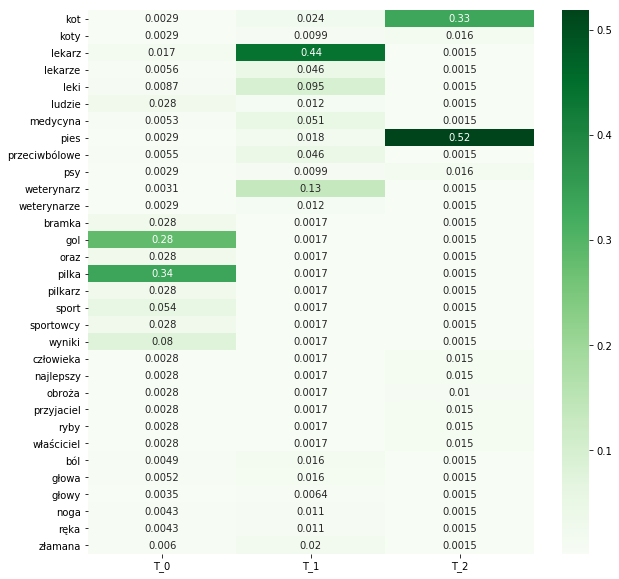

In [18]:
def plot_heatmap_docs_topics():
    theta = lda_model.get_document_topics()
    Index= [f'D_{i}' for i in range(0, M)]
    Cols = [f'T_{i}' for i in range(0, K)]
    df = pd.DataFrame(theta, index=Index, columns=Cols)

    plt.figure() # figsize=(10,5)
    sns.heatmap(df, annot=True, cmap="Greens")
    

def plot_heatmap_words_topisc():
    phi = lda_model.get_topics()
    Index = [id2word[i] for i in range(0, V)]
    Cols = [f'T_{i}' for i in range(0, K)]
    df = pd.DataFrame(np.transpose(phi), index=Index, columns=Cols)

    plt.figure(figsize=(10,10)) # figsize=(10,5)
    sns.heatmap(df, annot=True, cmap="Greens")


plot_heatmap_words_topisc()
# plot_heatmap_docs_topics()